* This notebook was to explore the effect of long river on salinity and surface current in the plume.

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import (viz_tools,tidetools,nc_tools)
import seaborn as sns
import matplotlib.gridspec as gridspec
import os
import arrow
from datetime import (
    datetime,
    timedelta,)
sns.set_style('darkgrid')

In [2]:
grid6 =nc.Dataset(
        '/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc',
        'r')
grid2 =nc.Dataset(
        '/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc',
        'r')
grids = [grid2,grid6]
Bathy = grid6.variables['Bathymetry'][:, :]
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]

In [4]:
def time_origin(dataset):
    """Return the time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :returns: Value of the time_origin attribute of the time_counter
              variable.
    :rtype: :py:class:`Arrow` instance
    """
    try:
        time_counter = dataset.variables['time_counter']
    except KeyError:
        raise KeyError('dataset does not have time_counter variable')
    try:
        time_origin = time_counter.time_origin.title()
    except AttributeError:
        raise AttributeError(
            'NetCDF: '
            'time_counter variable does not have time_origin attribute')
    value = arrow.get(time_origin, 'YYYY-MM-DD HH:mm:ss')
    return value

In [5]:
def timestamp(dataset, tindex):
    """Return the time stamp of the tindex time_counter value(s) in dataset.

    The time stamp is calculated by adding the time_counter[tindex] value
    (in seconds) to the dataset's time_counter.time_origin value.

    :arg dataset: netcdf dataset object
    :type dataset: :py:class:`netCDF4.Dataset`

    :arg tindex: time_counter variable index.
    :type tindex: int or list

    :returns: Time stamp value(s) at tindex in the dataset.
    :rtype: :py:class:`Arrow` instance or list of instances
    """
    time_orig = time_origin(dataset)
    time_counter = dataset.variables['time_counter']
    try:
        iter(tindex)
    except TypeError:
        tindex = [tindex]
    results = []
    for i in tindex:
        try:
            results.append(time_orig + timedelta(seconds=time_counter[i]))
        except IndexError:
            raise IndexError(
                'time_counter variable has no tindex={}'.format(tindex))
    if len(results) > 1:
        return results
    else:
        return results[0]

In [6]:
runs=['TS2','TS4']
base='/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides'
depths={};sals={}; Us={}; Vs={}
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1d_20030421_20030530_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline'][:]
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat'][:]
    T_lon = f.variables['nav_lon'][:]
    timesteps = f.variables['time_counter']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1d_20030421_20030530_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1d_20030421_20030530_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']
## for time t
path = os.path.join(base,'{}/SalishSea_1d_20030421_20030530_grid_T.nc'.format(runs[0]))
f = nc.Dataset(path,'r');
t_t = timestamp(f, np.arange(len(timesteps)))
for ind in range(len(t_t)):
    t_t[ind] = t_t[ind].datetime
tt = np.array(t_t)   

In [7]:
def quiver_salinity(t,dep,imin=1,imax=396,jmin=1,jmax=896,st=5,cmin= -4, cmax=4, dels = 0.4):
    "compare rivers and salinity at t, dep in box. st is quiver arrow interval"
    fig,axs = plt.subplots(1,3,figsize=(36,15))
    x=np.arange(imin,imax)
    y=np.arange(jmin,jmax)
    U={}; V={};u={};v={};uE={};vN={};
    for key, ax,grid in zip(runs,axs[:-1],grids):
        #truncate U/V and unstagger
        U[key]= Us[key][t,dep,jmin-1:jmax,imin-1:imax]
        V[key] =Vs[key][t,dep,jmin-1:jmax,imin-1:imax]
        lon=T_lon[jmin:jmax,imin:imax]
        lat=T_lat[jmin:jmax,imin:imax]
        S=sals[key][t,dep,jmin:jmax,imin:imax]
        S = np.ma.masked_values(S, 0)
        #masking
        U[key] = np.ma.masked_values(U[key],0)
        V[key] = np.ma.masked_values(V[key],0)
        #unstagger
        u[key],v[key] = viz_tools.unstagger(U[key],V[key])
        #rotate
        theta = np.pi*29/180
        uE[key] = u[key]*np.cos(theta) - v[key]*np.sin(theta)
        vN[key] = u[key]*np.sin(theta) +v[key]*np.cos(theta)
        #mesh
        mesh=ax.pcolormesh(lon,lat,S,cmap='spectral')
        viz_tools.plot_land_mask(ax,grid,coords='map',color='burlywood')
        #quivers
        quiver = ax.quiver(lon[::st,::st],lat[::st,::st],uE[key][::st,::st], vN[key][::st,::st],
                       pivot='mid', scale = 5, color='white',width=0.005)
        ax.quiverkey(quiver,-123.9,49., 1,'1 m/s',coordinates='data', color='black', labelcolor='black',\
                    fontproperties = {'size': '15'})
        cbar = plt.colorbar(mesh,ax=ax)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)
        cbar.set_label('Practical Salinity',fontsize = 20)
        ax.plot((-123.1,-123.8),(49,49.2),'k-')
        ax.set_xlim([-124.,-123])
        ax.set_ylim([48.9,49.4])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_title(key, fontsize = 20)       
    ##plot difference
    ax = axs[-1]
    sal_diff = sals[runs[1]][t,dep,jmin:jmax,imin:imax] - sals[runs[0]][t,dep,jmin:jmax,imin:imax]
    U_diff = uE[runs[1]] - uE[runs[0]]
    V_diff = vN[runs[1]] - vN[runs[0]]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=5, width=0.005, color='black' )
    ax.quiverkey(quiver,-123.9,49., 1, '1 m/s',coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
    cbar = plt.colorbar(mesh, ax=ax)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)
    cbar.set_label(' Salinity difference',fontsize = 20)
    ax.plot((-123.1,-123.8),(49,49.2),'k-')
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    ax.set_title('difference between TS2 & TS4',fontsize = 20)
    ax.set_xlim([-124.,-123])
    ax.set_ylim([48.9,49.4])
    return fig  

In [8]:
def salinity_transect_plot(t,dep):
    slats = np.linspace(49, 49.2, num=30, endpoint=True)
    slons = np.linspace(-123.1,-123.8, num=30, endpoint=True)
    ylat = np.zeros((30), dtype=np.int64)
    xlon = np.zeros((30), dtype=np.int64)
    for i, lat in enumerate(slats):
        lon = slons[i]
        ylat[i], xlon[i] = tidetools.find_closest_model_point(lon, lat, X, Y, Bathy, lat_tol=0.003)
    sals_0 = np.ma.masked_values(sals[runs[0]][t,dep], 0)
    sals_1 = np.ma.masked_values(sals[runs[1]][t,dep], 0)
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(slons, sals_0[ ylat, xlon], 'b*-',label = runs[0]);
    ax.plot(slons, sals_1[ ylat, xlon], 'go-',label = runs[1]);
    ax.legend(loc ='best', fontsize = 15)
    ax.set_xlim((-124,-123))
    ax.set_ylim((0,30))
    ax.set_xlabel('longitude [degree]')
    ax.set_ylabel('Practical Salinity')
    return fig

In [9]:
def min_sal(dep):
    """To plot min salinity value and location of a fixed depth"""
    min_sals = {runs[0]:[],runs[1]:[]};min_lons = {runs[0]:[],runs[1]:[]};
    slats = np.linspace(49, 49.2, num=30, endpoint=True)
    slons = np.linspace(-123.1,-123.8, num=30, endpoint=True)
    ylat = np.zeros((30), dtype=np.int64)
    xlon = np.zeros((30), dtype=np.int64)
    for i, lat in enumerate(slats):
        lon = slons[i]
        ylat[i], xlon[i] = tidetools.find_closest_model_point(lon, lat, X, Y, Bathy, lat_tol=0.003)
    T_lon_zoomin = T_lon[ylat,xlon];
    for run in runs:
        for t in np.arange(len(timesteps)):
            sal = np.ma.masked_values(sals[run][t,dep,ylat,xlon], 0)
            i = np.where(sal == np.nanmin(sal))
            min_sals[run].append(np.nanmin(sal))
            min_lons[run].append(T_lon_zoomin[i])
    ##plot
    fig, axs = plt.subplots(2,1,figsize = [8,8])
    combines = [min_sals,min_lons];
    for ax, combine in zip(axs, combines):
        ax.plot(tt,combine[runs[0]], 'b^-',label = runs[0])
        ax.plot(tt,combine[runs[1]],'r*-',label = runs[1])
        ax.legend(loc = 'best')
        ax.set_xlabel('Time')
    axs[0].set_ylabel('Practical Salinity')
    axs[1].set_ylabel('Longitude [degree]')
    axs[1].set_ylim(-124.,-123.)
    return fig

# Surface layer

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


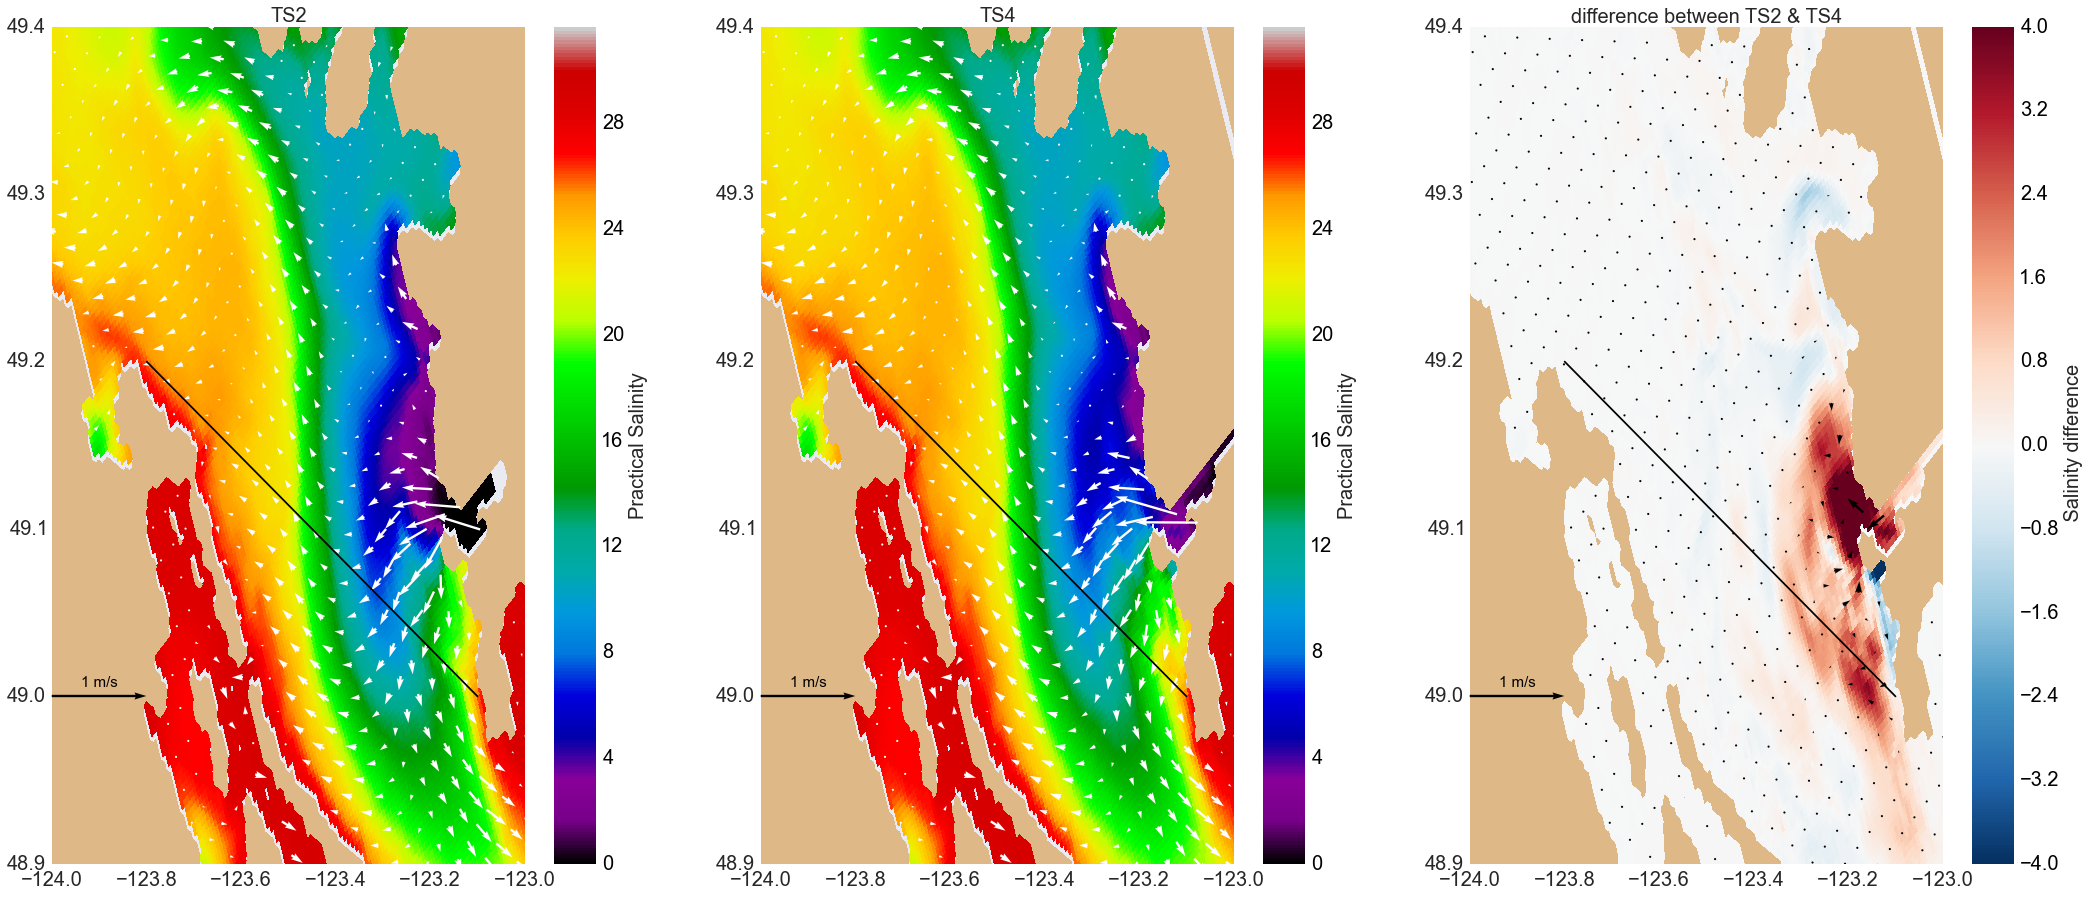

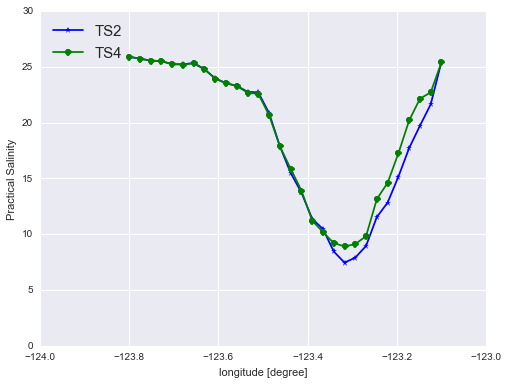

In [10]:
## start day & surface currents
t=0; dep=0
fig=quiver_salinity(t,dep)
fig = salinity_transect_plot(t,dep)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


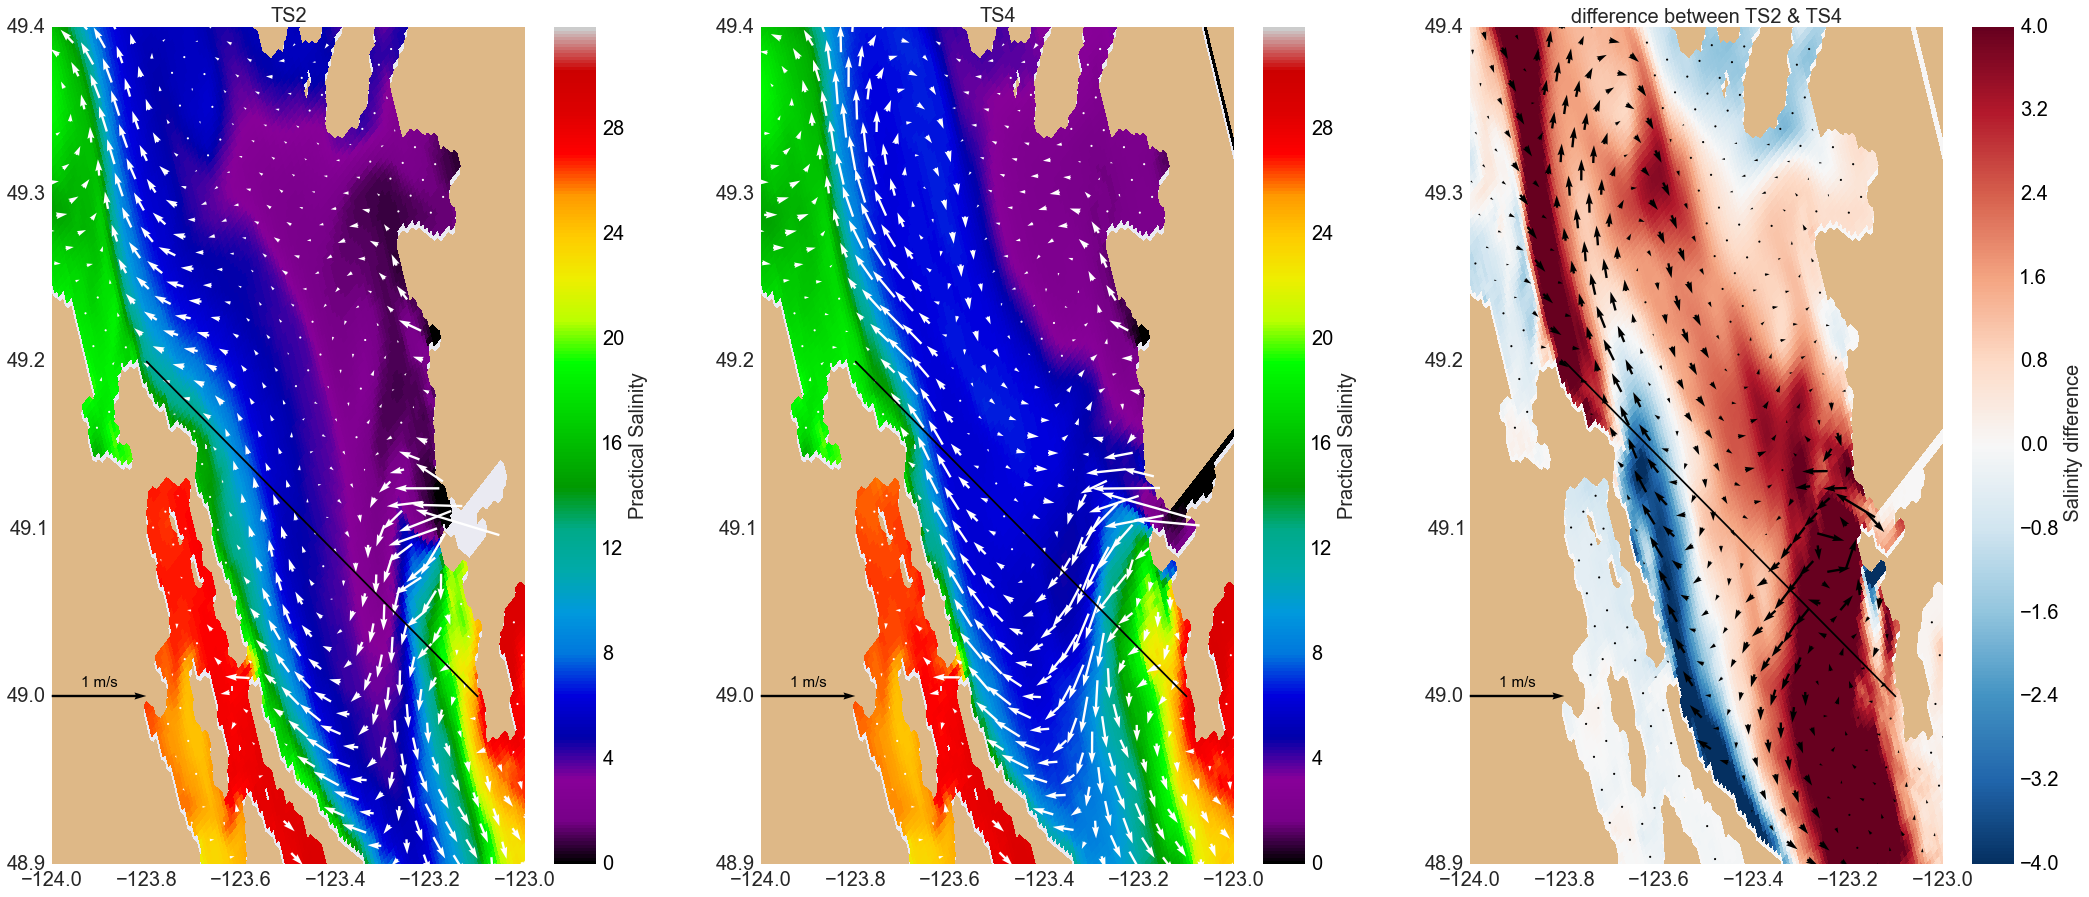

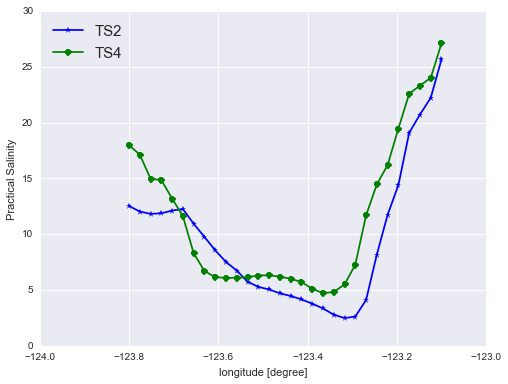

In [11]:
## end of this period & surface currents
t=39; dep=0
fig=quiver_salinity(t,dep)
fig = salinity_transect_plot(t,dep)

# 1.5m

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


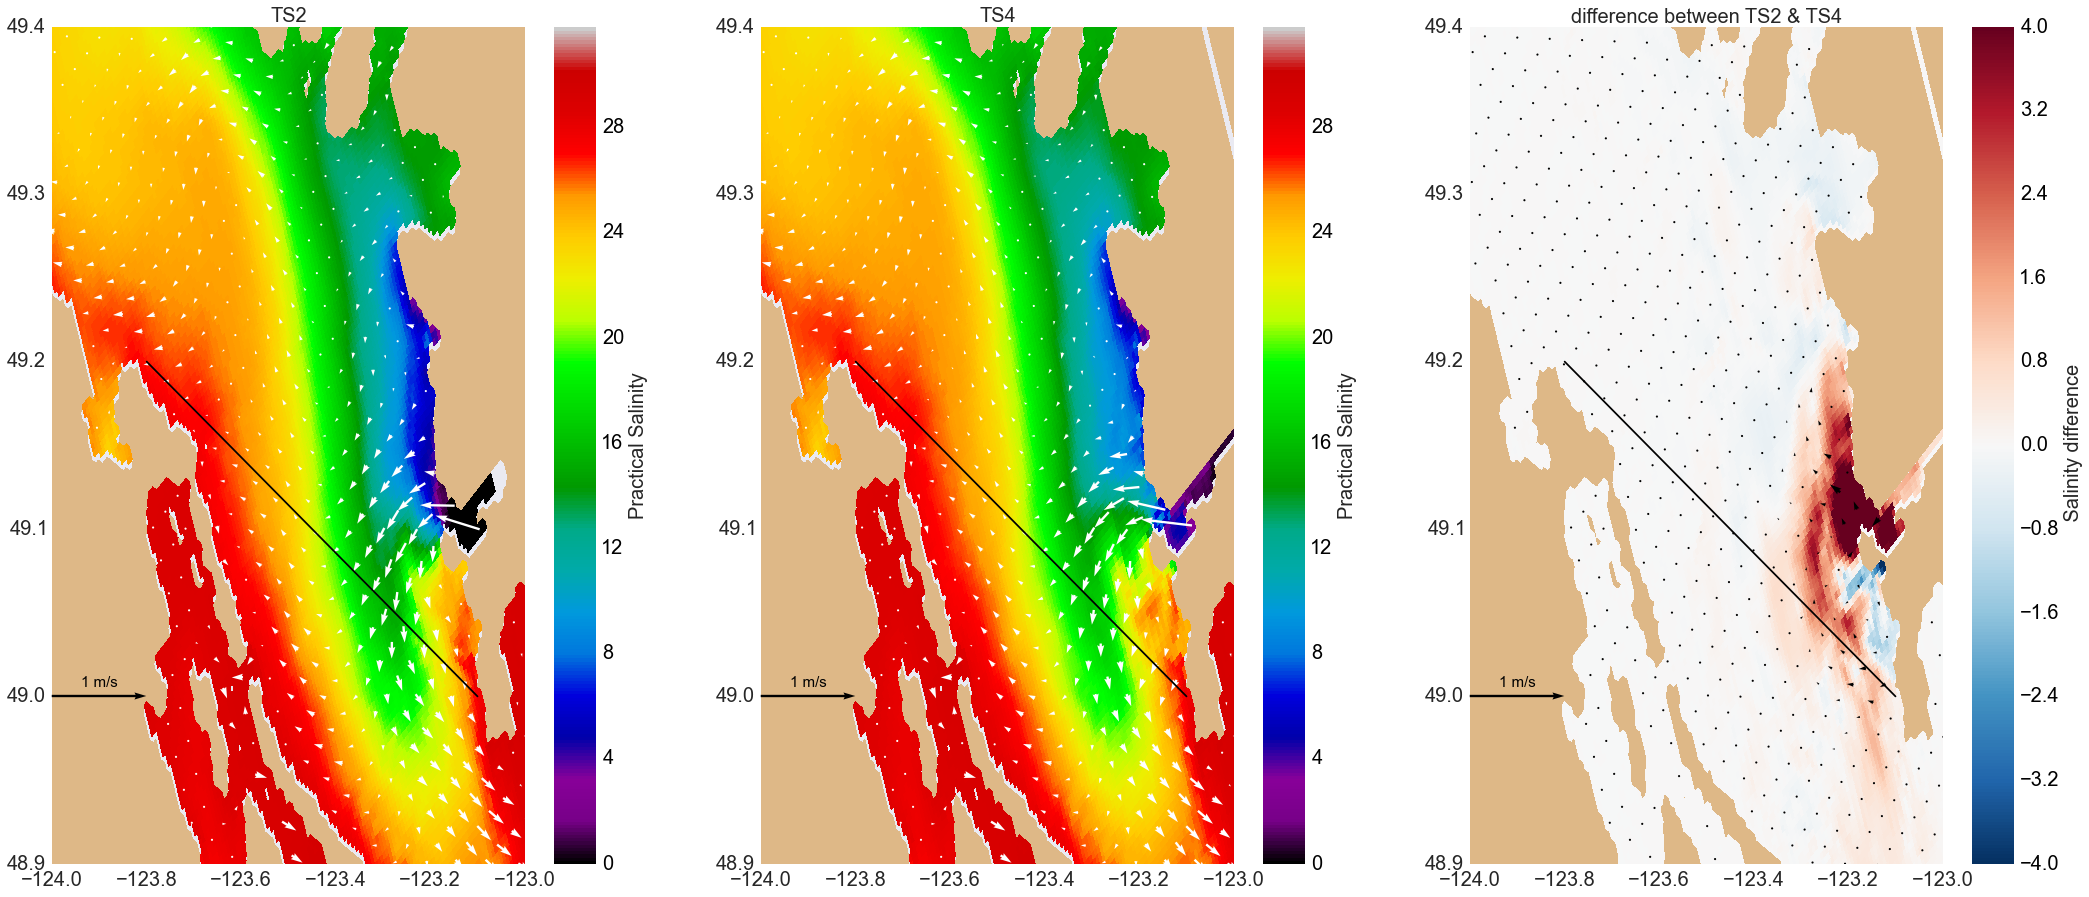

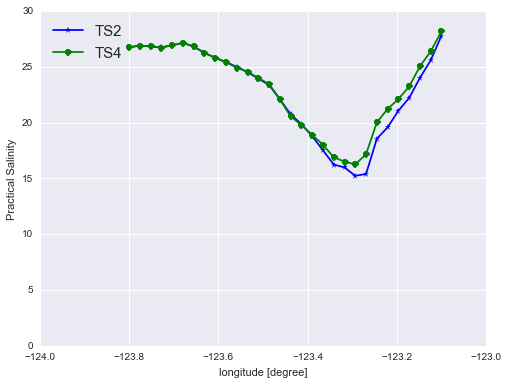

In [12]:
## start day & 1.5m 
t=0; dep=1
fig=quiver_salinity(t,dep)
fig = salinity_transect_plot(t,dep)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


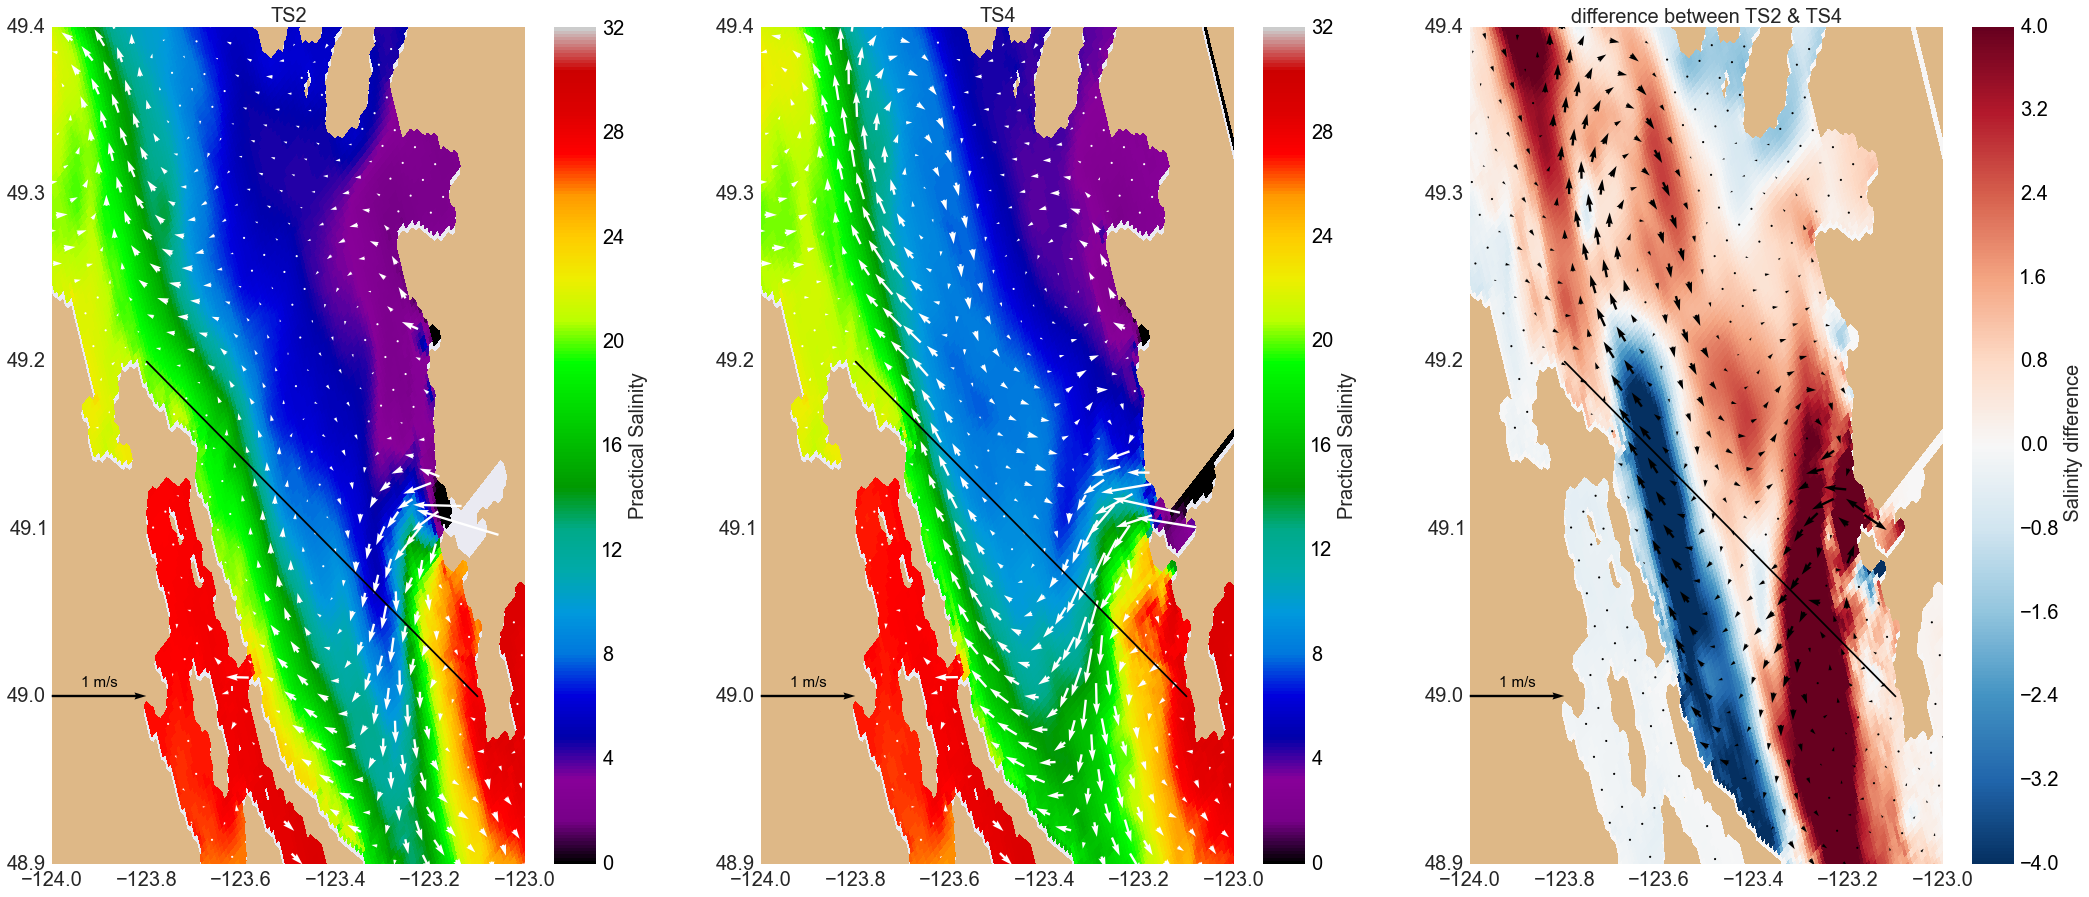

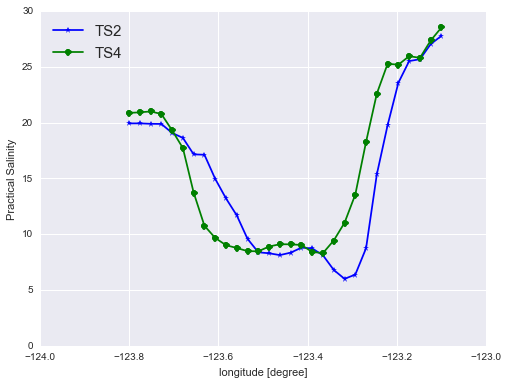

In [13]:
t=39; dep=1
fig=quiver_salinity(t,dep)
fig = salinity_transect_plot(t,dep)

# Magnitude of u velocity

In [14]:
def magnitude(t,dep,imin=1,imax=396,jmin=1,jmax=896,st=5,cmin= -1, cmax=1, dels = 0.4):
    "compare rivers and salinity at t, dep in box. st is quiver arrow interval"
    fig,axs = plt.subplots(1,3,figsize=(36,15))
    x=np.arange(imin,imax)
    y=np.arange(jmin,jmax)
    U={}; V={};u={};v={};uE={};vN={};
    for key, ax,grid in zip(runs,axs[:-1],grids):
        #truncate U/V and unstagger
        U[key]= Us[key][t,dep,jmin-1:jmax,imin-1:imax]
        V[key] =Vs[key][t,dep,jmin-1:jmax,imin-1:imax]
        lon=T_lon[jmin:jmax,imin:imax]
        lat=T_lat[jmin:jmax,imin:imax]
        S=sals[key][t,dep,jmin:jmax,imin:imax]
        S = np.ma.masked_values(S, 0)
        #masking
        U[key] = np.ma.masked_values(U[key],0)
        V[key] = np.ma.masked_values(V[key],0)
        #unstagger
        u[key],v[key] = viz_tools.unstagger(U[key],V[key])
        #rotate
        theta = np.pi*29/180
        uE[key] = u[key]*np.cos(theta) - v[key]*np.sin(theta)
        vN[key] = u[key]*np.sin(theta) +v[key]*np.cos(theta)
        #mesh
        mesh=ax.pcolormesh(lon,lat,uE[key],cmap='bwr')
        viz_tools.plot_land_mask(ax,grid,coords='map',color='burlywood')
        #quivers
        quiver = ax.quiver(lon[::st,::st],lat[::st,::st],uE[key][::st,::st], vN[key][::st,::st],
                       pivot='mid', scale = 5, color='white',width=0.005
                       )
        ax.quiverkey(quiver,-123.9,49., 1,'1 m/s',coordinates='data', color='black', labelcolor='black',\
                    fontproperties = {'size': '15'})
        cbar = plt.colorbar(mesh,ax=ax)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)
        cbar.set_label('U velocity',fontsize = 20)
        ax.plot((-123.1,-123.8),(49,49.2),'k-')
        ax.set_xlim([-124.,-123])
        ax.set_ylim([48.9,49.4])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_title(key, fontsize = 20)       
    ##plot difference
    ax = axs[-1]
    uE_diff = uE[runs[1]] - uE[runs[0]]
    vN_diff = vN[runs[1]] - vN[runs[0]]
    mesh=ax.pcolormesh(lon,lat,uE_diff,cmap='bwr',vmin=cmin, vmax=cmax)
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st],uE_diff[ ::st, ::st], vN_diff[::st,::st],\
                           pivot='mid',scale=5, width=0.005, color='black' )
    ax.quiverkey(quiver,-123.9,49., 1, '1 m/s',
                        coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
    cbar = plt.colorbar(mesh, ax=ax)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)
    cbar.set_label(' U velocity difference',fontsize = 20)
    ax.plot((-123.1,-123.8),(49,49.2),'k-')
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    ax.set_title('difference between TS2 & TS4',\
                     fontsize = 20)
    ax.set_xlim([-124.,-123])
    ax.set_ylim([48.9,49.4])
    return fig  

* surface layer

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


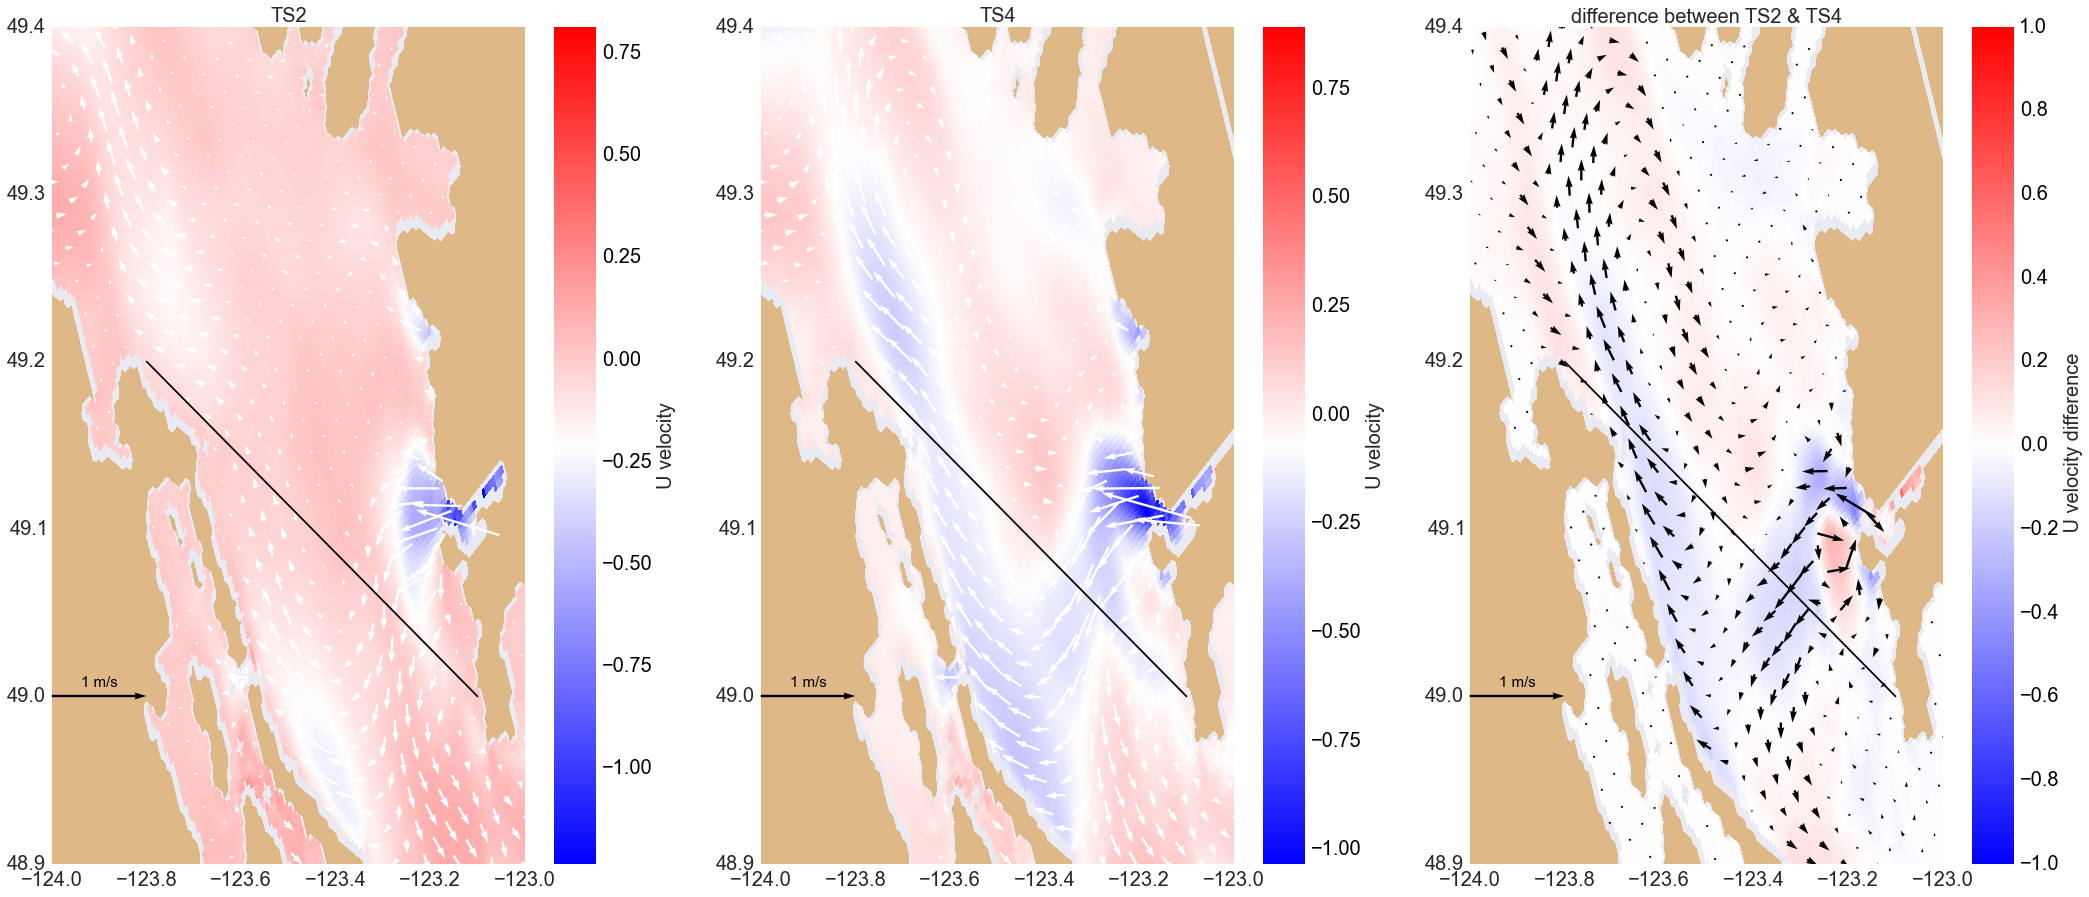

In [15]:
t=39; dep=0
fig=magnitude(t,dep)

* 1.5 m

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


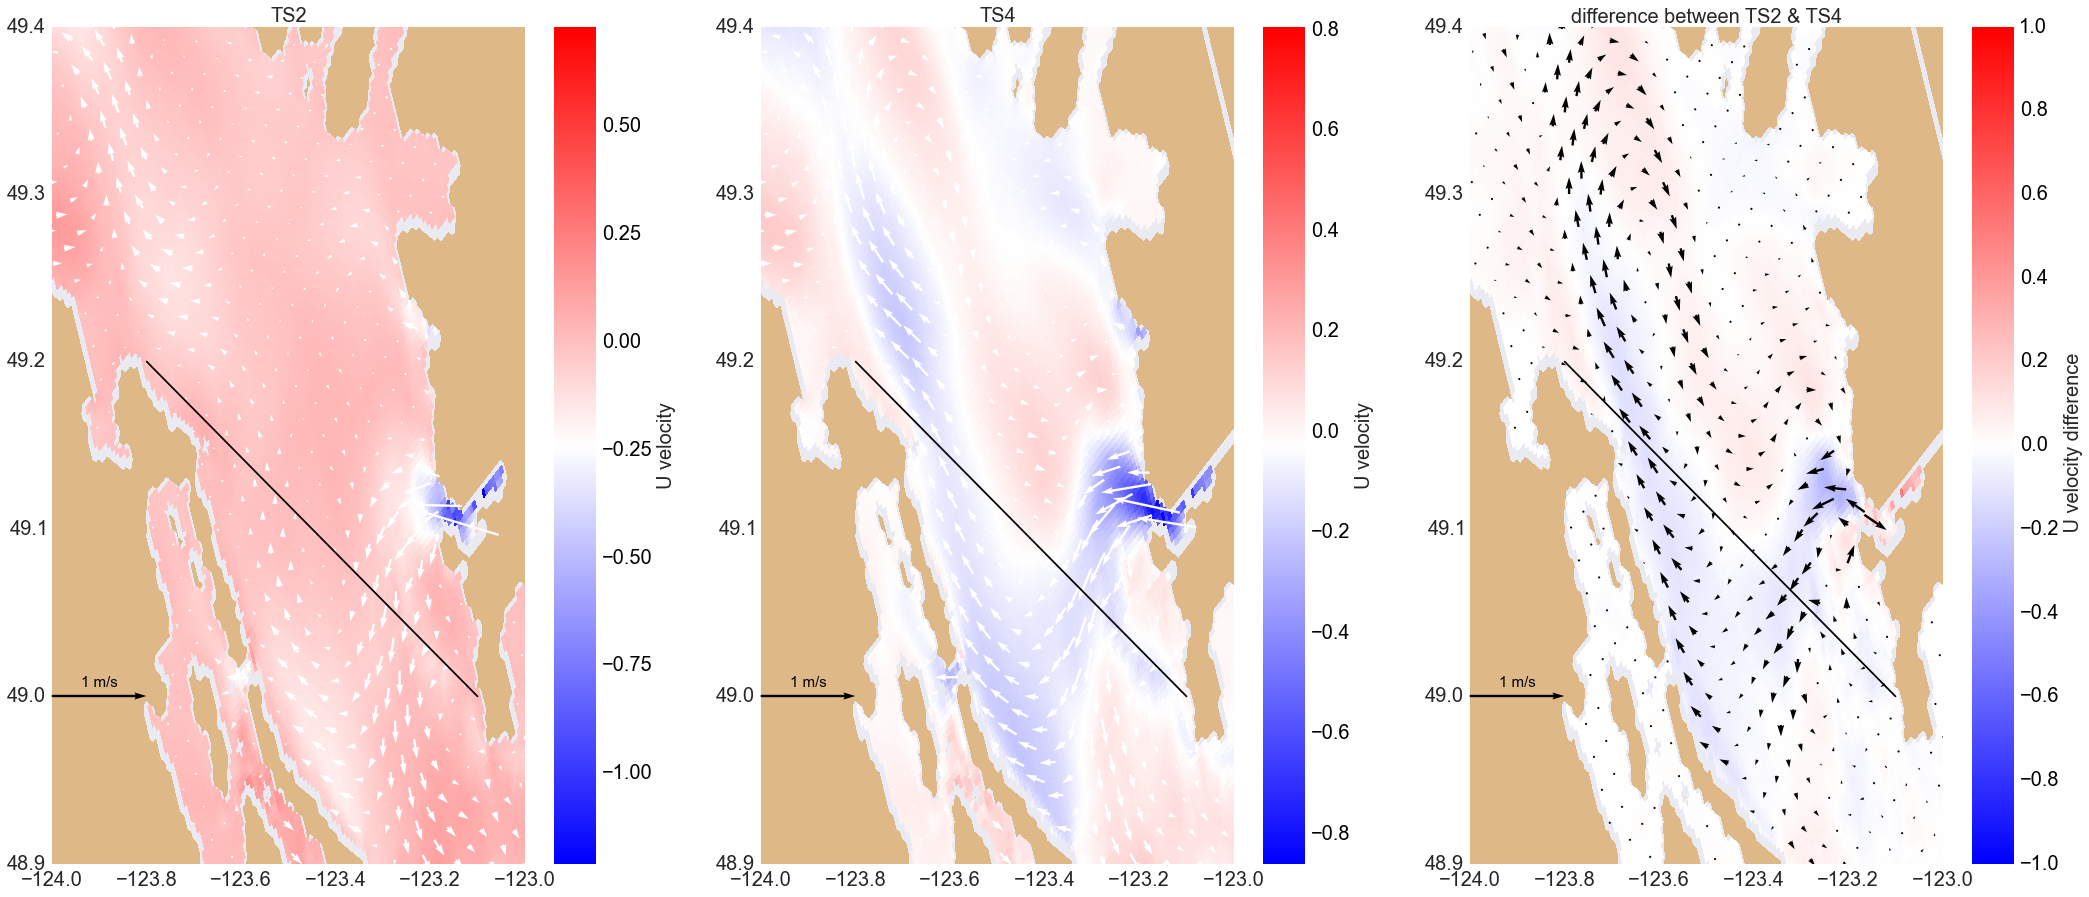

In [16]:
t=39; dep=1
fig=magnitude(t,dep)

# Minimum salinity value, location

* surface layer

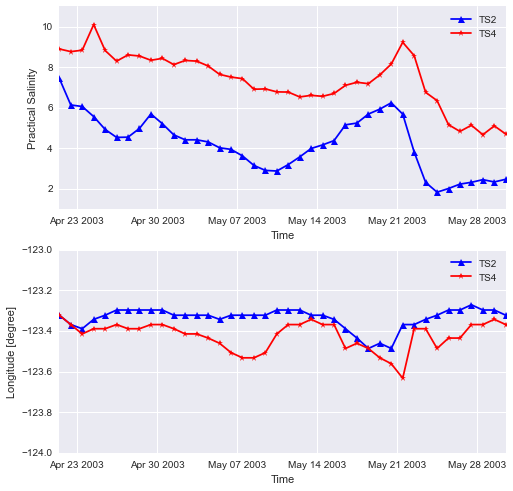

In [17]:
fig = min_sal(0)

* 1.5 m

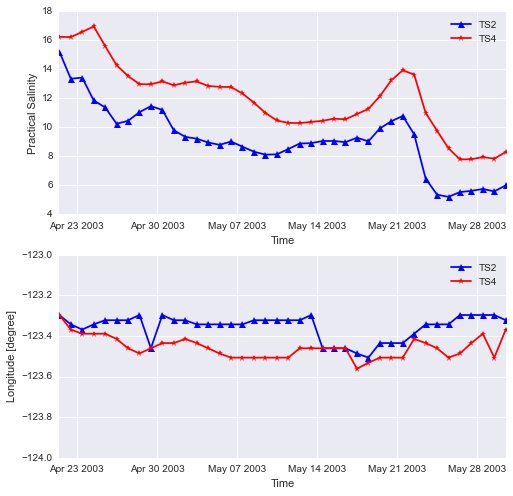

In [18]:
fig = min_sal(1)

# Check fresh water flux at river mouth

In [19]:
def freshwater_transect_plot(dep, number,imin=1,imax=396,jmin=1,jmax=896):
    """To calculate freshwater flux cross the transect right at river mouth"""
    slats = np.linspace(49.09, 49.14, num=number, endpoint=True)
    slons = -123.2
    ylat = np.zeros((number), dtype=np.int64)
    xlon = np.zeros((number), dtype=np.int64)
    sdx_0 = []; sdx_1 = [];sum_sdx0 =[];sum_sdx1 = [];
    for i, lat in enumerate(slats):
        lon = slons
        ylat[i], xlon[i] = tidetools.find_closest_model_point(lon, lat, X, Y, Bathy, lat_tol=0.003)
    sals_0 = np.ma.masked_values(sals[runs[0]][:,dep,:,:], 0)
    sals_1 = np.ma.masked_values(sals[runs[1]][:,dep,:,:], 0)
    for t in range(40): ## 40 daily files
        for i in range(number): ## every single grid point 
            if i != number-1: ## but not for the last point
                sdx_0.append((30-sals_0[t,ylat[i],xlon[i]])* np.diff(slats)[i] *111 * np.cos(np.pi*slats[i]/180))
                sdx_1.append((30-sals_1[t,ylat[i],xlon[i]])* np.diff(slats)[i] *111 * np.cos(np.pi*slats[i]/180))
            else: ## if it is the last point
                sdx_0.append(0)
                sdx_1.append(0)
                sum_sdx0.append(sum(sdx_0[number*t:number*(t+1)]))
                sum_sdx1.append(sum(sdx_1[number*t:number*(t+1)]))
    ## plot
    fig = plt.figure(figsize = [14,5]); ax0 = fig.add_subplot(121)
    ax0.plot(tt,sum_sdx0, 'b^-', label = runs[0])
    ax0.plot(tt,sum_sdx1, 'r*-', label = runs[1])
    ax0.legend(loc ='best'); ax0.set_title(str(depths[runs[1]][dep])+' m')
    ax0.set_xlabel('Time [utc]');ax0.set_ylabel('Fresh Water Flux [s*km]')
    ax1= fig.add_subplot(122); x=np.arange(imin,imax); y=np.arange(jmin,jmax)
    viz_tools.plot_land_mask(ax1,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(ax1,grid6,coords='map')
    viz_tools.plot_coastline(ax1,grid6,coords='map',isobath=4,color='FireBrick')
    viz_tools.plot_coastline(ax1,grid6,coords='map',isobath=20,color='OrangeRed')
    ax1.plot((-123.2,-123.2),(49.14,49.09),'k-')
    ax1.set_xlim([-124.,-123])
    ax1.set_ylim([48.9,49.4])
    return fig

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


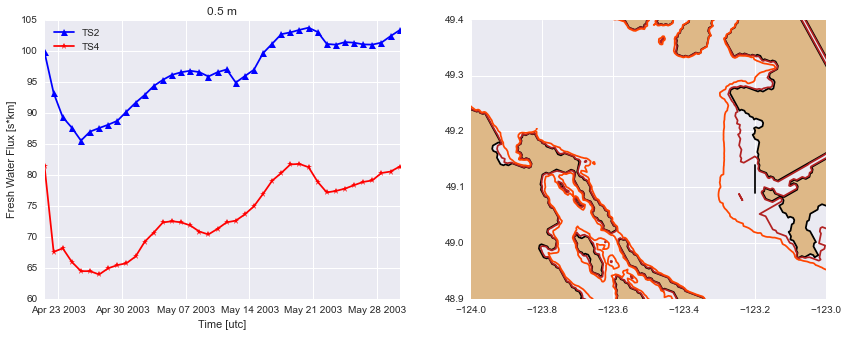

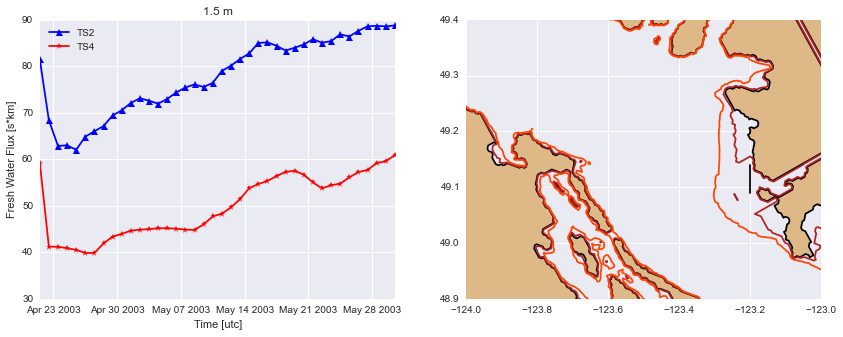

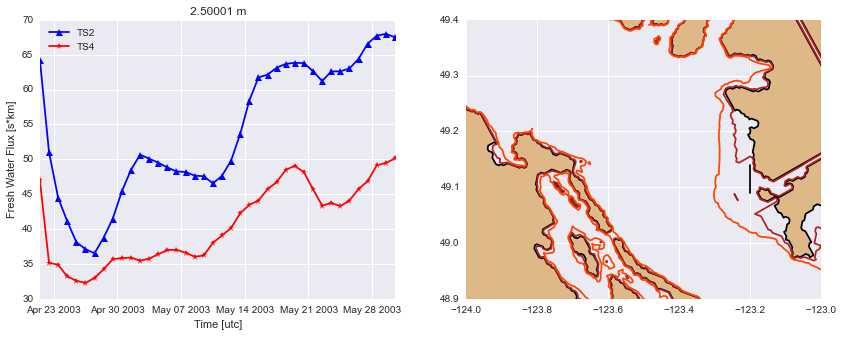

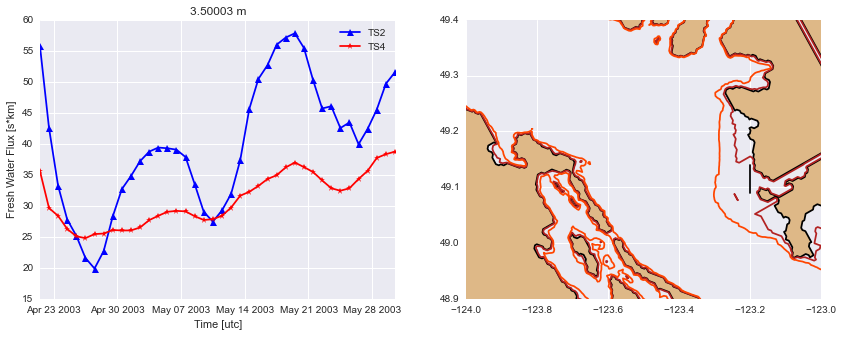

In [20]:
## different layers, note old bathy the depth is 4 m, new bathy is deepened to 9 m.
fig = freshwater_transect_plot(0, 10)
fig = freshwater_transect_plot(1, 10)
fig = freshwater_transect_plot(2, 10)
fig = freshwater_transect_plot(3, 10)

* Roughly 4 psu salinity difference for the upper 3m depths. I think this can account for most of the reason why minimum salinity is saltier in the new bathy rather than mixing vertically.

# What's the salinity field like in the river channel?

In [21]:
def vertical_plot(j0,i0,j1,i1,zmax, zmin,imin=1,imax=396,jmin=1,jmax=896):
    """plot the vertical profile of salinity for both results"""
    sals_0 = np.ma.masked_values(sals[runs[0]][:,:, j0,i0], 0)
    sals_1 = np.ma.masked_values(sals[runs[1]][:,:,j1,i1], 0) 
    ## plot vertical profiles
    ts = [0,19,39]
    fig = plt.figure(figsize=(18,12));gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1,1])
    ax0 = fig.add_subplot(gs[0, 0]); ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[0, 2]); axx = [ax0, ax1, ax2]
    ax3 = fig.add_subplot(gs[1, 0])
    for t,ax in zip(ts,axx):
        ax.plot(sals_0[t], depths[runs[0]],'b^-',label = runs[0])
        ax.plot(sals_1[t], depths[runs[1]],'r*-',label = runs[1])
        ax.legend(loc = 'best'); ax.set_title('t= '+str(t))
        ax.set_ylim([zmax,zmin]);ax.set_xlabel('Practical Salinity')
        ax.set_ylabel('Depth [m]')
    ## plot map
    x=np.arange(imin,imax); y=np.arange(jmin,jmax)
    viz_tools.plot_land_mask(ax3,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(ax3,grid6,coords='map')
    viz_tools.plot_coastline(ax3,grid6,coords='map',isobath=4,color='FireBrick')
    viz_tools.plot_coastline(ax3,grid6,coords='map',isobath=20,color='OrangeRed')
    ax3.plot(T_lon[j0,i0],T_lat[j0,i0],'b^')
    ax3.plot(T_lon[j1,i1],T_lat[j1,i1],'g*')
    ax3.set_xlim([-123.6,-122.5])
    ax3.set_ylim([49.0,49.6])
    return fig

* Take a look at the edge of both bathymetry first.

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


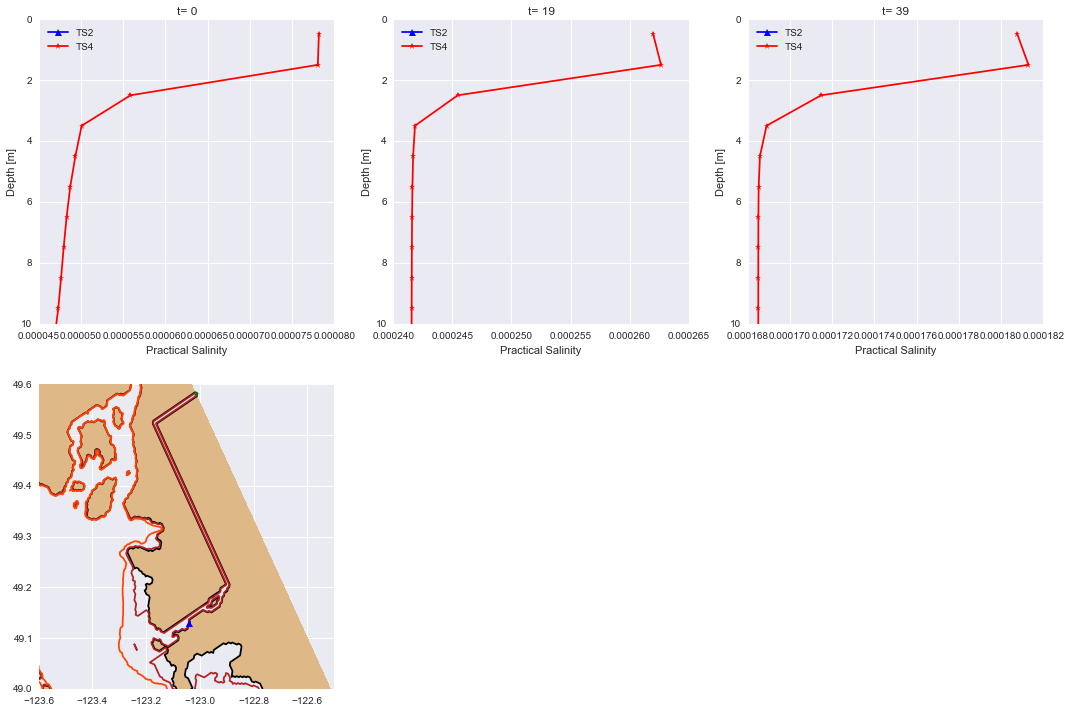

In [22]:
fig = vertical_plot(414,334,500,395,10,0)

* in the straight north river channel

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


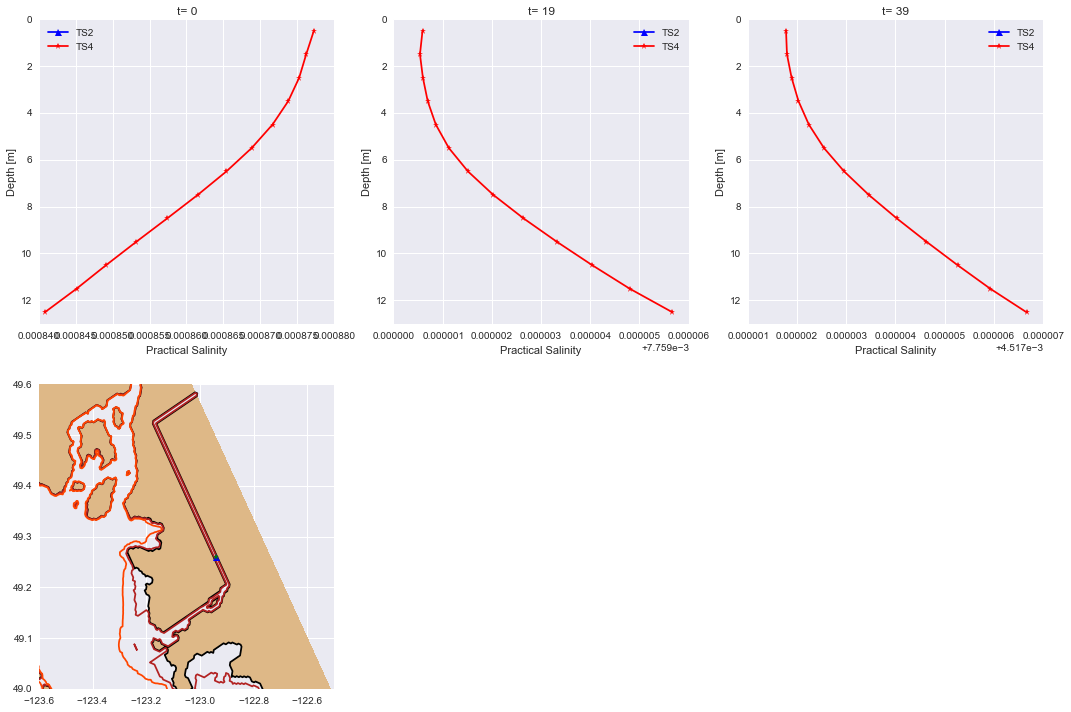

In [23]:
fig = vertical_plot(432,365,432,365,13,0)

* edge of straight channel

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


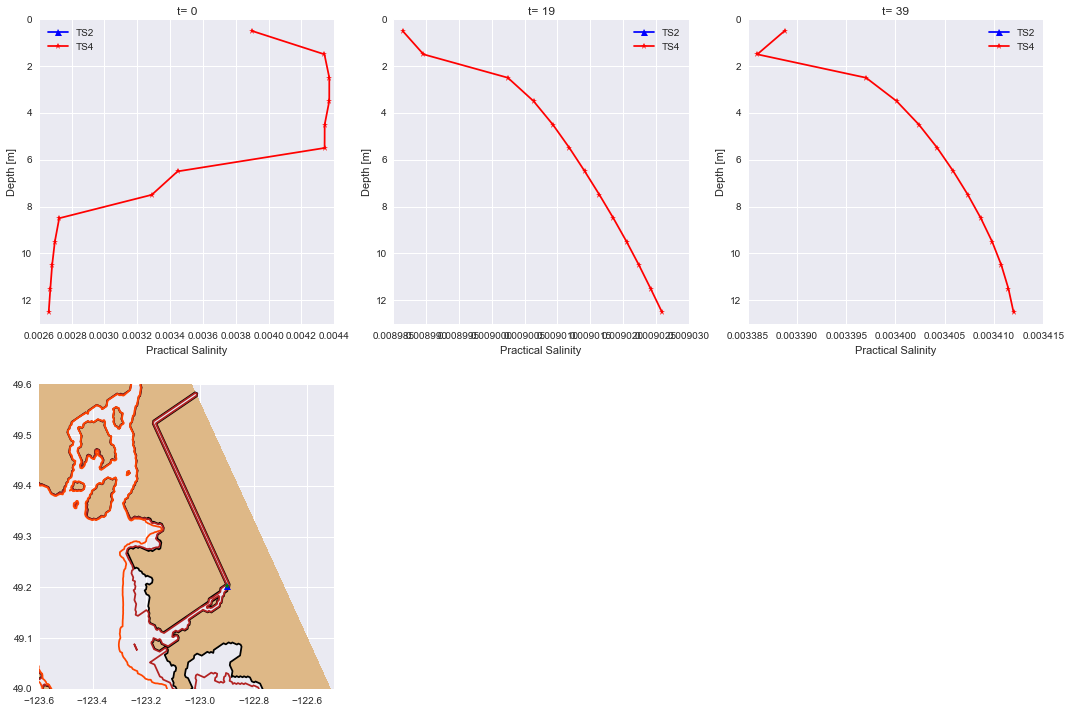

In [24]:
fig = vertical_plot(418,364,418,364,13,0)

* inside straight channel

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


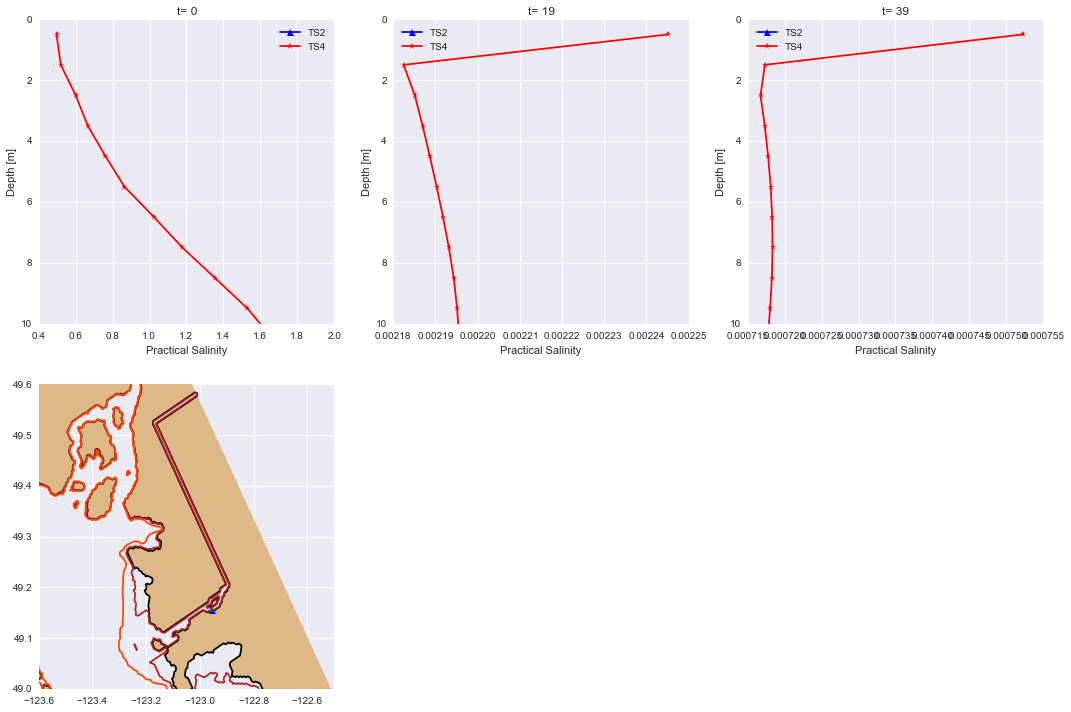

In [25]:
fig = vertical_plot(413,350,413,350,10,0)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


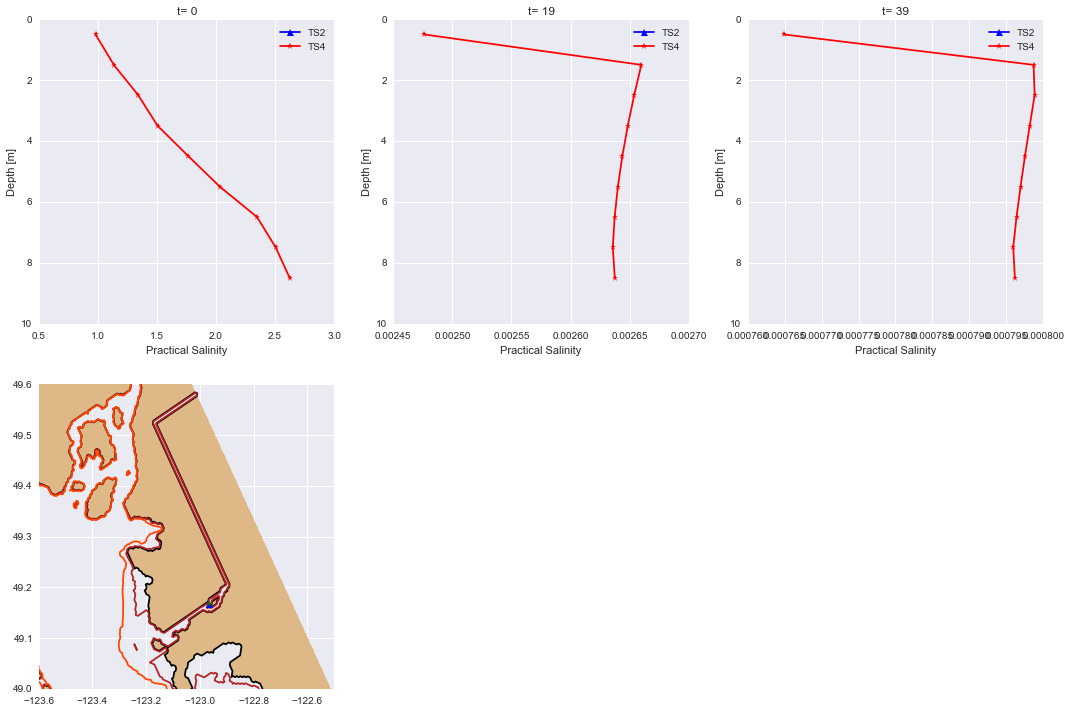

In [26]:
fig = vertical_plot(416,350,416,350,10,0)

* in the old channel

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


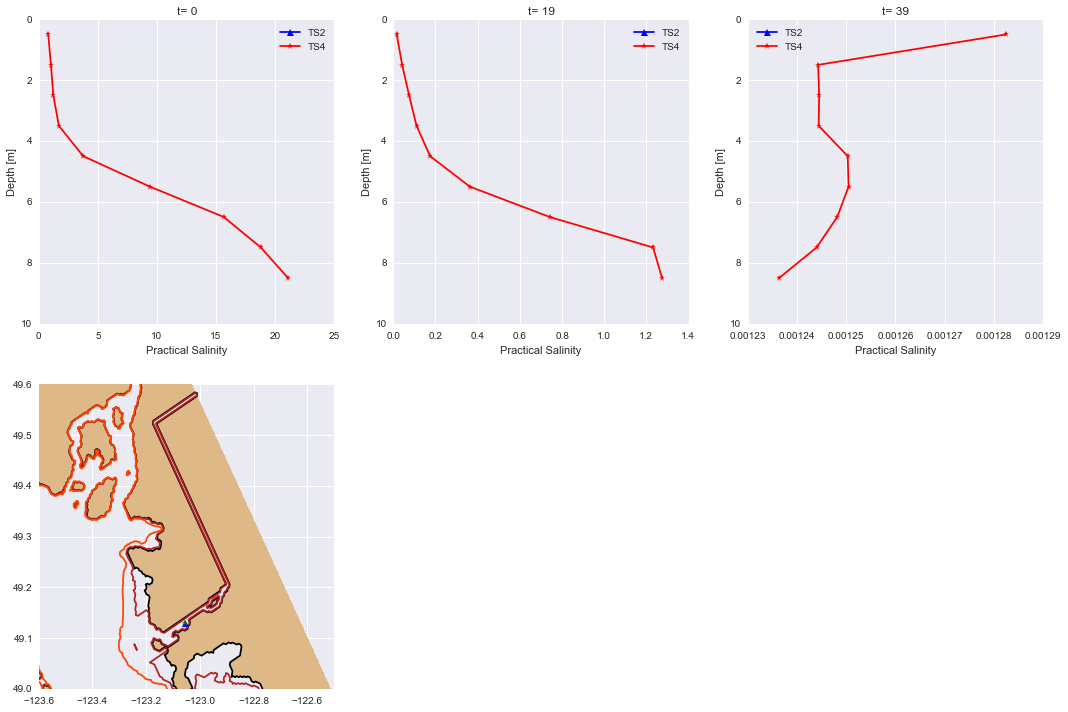

In [27]:
fig = vertical_plot(415,332,415,332,10,0)

* at the mouth point

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


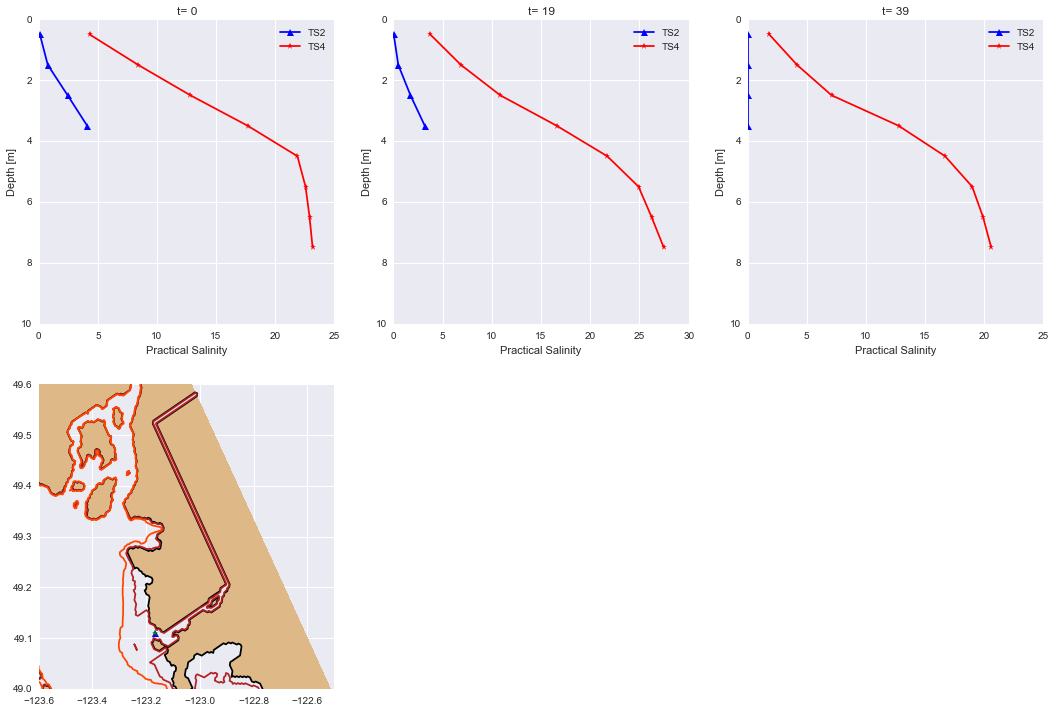

In [28]:
## mouth point
fig = vertical_plot(419,313,419,313,10,0)

* in the strait

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


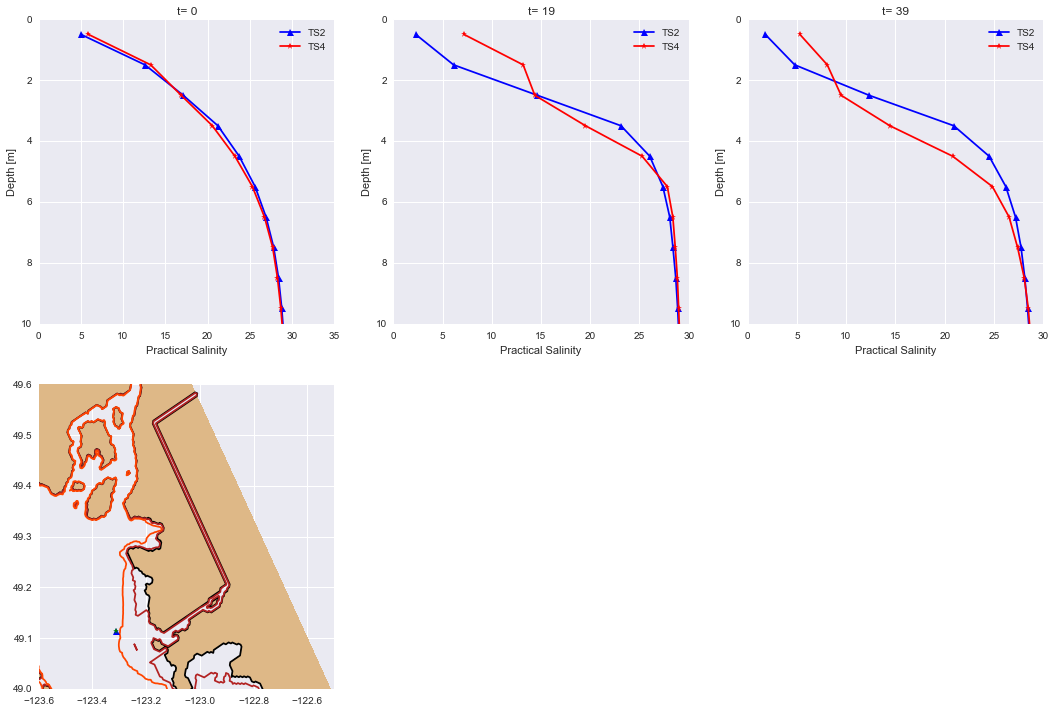

In [29]:
fig = vertical_plot(430,292,430,292,10,0)

* In the new bathymetry, the river channel region does not seem to mix up itself as the salinity values are tiny.
* Big discrepency between salinity values at the mouth may be caused by longer and deeper river channel, and thus weaker river flow at the mouth, more salinity intrusion than the short river channel, that makes river mouth region saltier.

# Check daily surface currents

In [30]:
sites = {'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 426,
        'j' : 293
   },'Deas Island':{
        'lat' : 48.12,
        'lon' : -123.07,
        'i' : 414,
        'j' : 328
    }, 'New Westminster': {
        'lat': 49.21,
        'lon': -122.89,
        'i': 418,
        'j': 365
        },'Mission': {
        'lat': 48.59,
        'lon': -123.2,
        'i':  500,
        'j':367
    },}

In [31]:
def compare_surfacecurrent_at_stns(dep,run):
    '''This function was made to compare surface currents at different 
        Fraser River stations during a time period'''
    ##some constant parameters
    fig, axs = plt.subplots(2, 1, figsize=(15, 8))
    names = ['Sandheads', 'Deas Island', 'New Westminster', 'Mission']
    colors = ['g','DodgerBlue','tomato','Olive']
    ax = axs[0]
    for name,c in zip(names,colors):
        ax.plot(tt, Us[run][:,dep,sites[name]['i'], sites[name]['j']], color = c,linewidth = 2, label = name)
        ax.set_title(run,fontsize = 12)
        ax.set_ylabel('zonal surface current U (m/s)', fontsize = 12)

    ax = axs[1]
    for name, c in zip(names,colors):
        ax.plot(tt, Vs[run][:,dep,sites[name]['i'], sites[name]['j']], color = c,linewidth = 2, label = name)
        ax.set_title(run,fontsize = 12)
        ax.set_ylabel('meridional surface current V (m/s)', fontsize = 12)
    for ax in axs:
        ax.set_ylim([-1,1])
        ax.set_xlim()
        ax.set_xlabel('Time [utc]', fontsize = 12)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
        legend = ax.legend(loc = 'best')
        legend.get_title().set_fontsize('12')
    return fig 

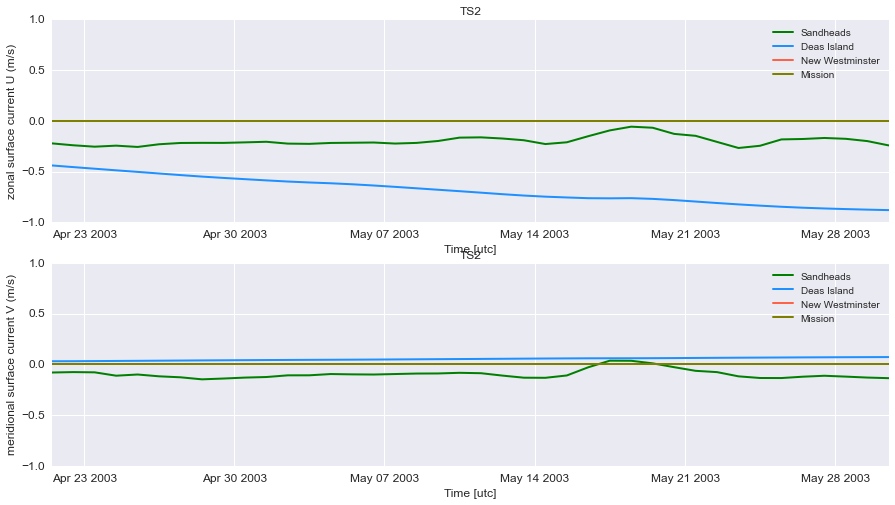

In [32]:
fig = compare_surfacecurrent_at_stns(0,runs[0])

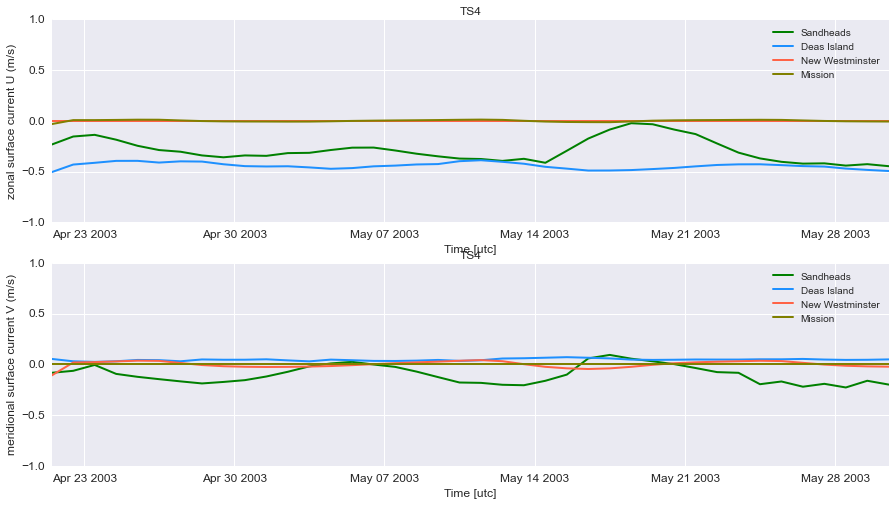

In [33]:
fig = compare_surfacecurrent_at_stns(0,runs[1])

* Not a good way to look at it as they are all averaged over a day, will look at it in hourly results from last hindcast comparison